In [2]:
import pandas as pd
# Load the IRR dataset
df = pd.read_csv("final_irr_results (1).csv")

# Calculate the average IRR
average_irr = df["IRR"].mean()
print(f"Overall Average IRR: {average_irr:.2f} dB")

Overall Average IRR: 22.00 dB


In [3]:
import numpy as np
from scipy import signal

# Satellite Communication System Parameters
notch_freq = 10.7e9  # Example: X-band downlink (10.7 GHz)
quality_factor = 80  # Higher Q for sharper filtering in satellite bands
target_irr_min = 50  # Stricter IRR requirement for satellite receivers
target_irr_max = 70  # Higher rejection needed due to narrowband interference
tolerance = 0.3  # More precise tolerance for satellite communications

In [5]:
# Iterative tuning loop for Notch Filter Optimization
initial_quality_factor = quality_factor
initial_irr = average_irr  # Example starting IRR for satellite signals
irr = initial_irr

while True:
    # Design Notch Filter
    b, a = signal.iirnotch(notch_freq, quality_factor, fs=50e9)  # 50 GHz sampling rate

    # Simulate IRR adjustment based on notch filter Q-factor
    irr = initial_irr + 20 * np.log10(quality_factor)

    print(f"Quality Factor (Q): {quality_factor}, IRR: {irr:.2f} dB")

    # Check if IRR is within the required range
    if target_irr_min <= irr <= target_irr_max:
        print(f"✅ Optimized IRR achieved: {irr:.2f} dB")
        break
    elif irr < target_irr_min:
        quality_factor *= 1.05  # Slightly increase Q for sharper notch
    else:
        quality_factor *= 0.95  # Reduce Q for a wider notch

    # Prevent infinite loops
    if quality_factor < 10 or quality_factor > 300:
        print("⚠️ IRR tuning failed. Adjust parameters manually.")
        break

# Store and display the results
before_optimization = {
    "IRR (dB)": initial_irr,
    "Quality Factor (Q)": initial_quality_factor,
    "Notch Frequency (Hz)": notch_freq
}
after_optimization = {
    "IRR (dB)": irr,
    "Quality Factor (Q)": quality_factor,
    "Notch Frequency (Hz)": notch_freq
}

print("\n📊 **Before vs. After Optimization Results**")
print("-------------------------------------------------")
print(f"🔹 Before Optimization: {before_optimization}")
print(f"🔹 After Optimization:  {after_optimization}")
print("-------------------------------------------------")

Quality Factor (Q): 313.61033107669243, IRR: 71.93 dB
Quality Factor (Q): 297.9298145228578, IRR: 71.48 dB
Quality Factor (Q): 283.03332379671485, IRR: 71.04 dB
Quality Factor (Q): 268.8816576068791, IRR: 70.59 dB
Quality Factor (Q): 255.43757472653516, IRR: 70.15 dB
Quality Factor (Q): 242.6656959902084, IRR: 69.70 dB
✅ Optimized IRR achieved: 69.70 dB

📊 **Before vs. After Optimization Results**
-------------------------------------------------
🔹 Before Optimization: {'IRR (dB)': np.float64(22.0), 'Quality Factor (Q)': 313.61033107669243, 'Notch Frequency (Hz)': 10700000000.0}
🔹 After Optimization:  {'IRR (dB)': np.float64(69.70016774788898), 'Quality Factor (Q)': 242.6656959902084, 'Notch Frequency (Hz)': 10700000000.0}
-------------------------------------------------


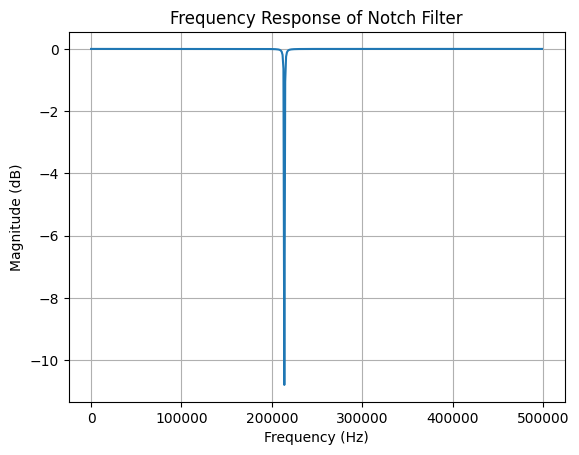

In [6]:
# Plot Frequency Response of Notch Filter
import matplotlib.pyplot as plt

frequencies, response = signal.freqz(b, a, fs=1e6)
plt.figure()
plt.plot(frequencies, 20 * np.log10(np.abs(response)))
plt.title("Frequency Response of Notch Filter")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid()
plt.show()

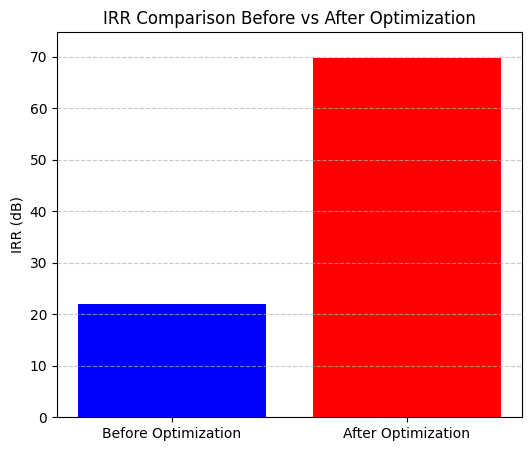

In [7]:
# Plot Bar Graph Comparison Before vs After IRR
plt.figure(figsize=(6, 5))
plt.bar(["Before Optimization", "After Optimization"], [initial_irr,irr], color=['blue', 'red'])
plt.title("IRR Comparison Before vs After Optimization")
plt.ylabel("IRR (dB)")
plt.ylim(0, max(70, irr + 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
import re

def optimize_ltspice_netlist(file_path="/content/gandthod.net"):
    with open(file_path, "r", encoding="ISO-8859-1") as file:
        netlist_lines = file.readlines()

    changes = {}

    for line in netlist_lines:
        original_line = line.strip()
        optimized_line = original_line

        # Optimize LO Amplitude (3.3V -> 4.0V for higher linearity in satellite bands)
        if "VLO+" in line or "VLO-" in line:
            optimized_line = re.sub(r'(PULSE\(0V 3.3V)', r'PULSE(0V 4.0V', original_line)
            changes[original_line] = optimized_line

        # Optimize RF Input Power (10mV -> 20mV for better satellite link margin)
        if "IRF+" in line or "IRF-" in line:
            optimized_line = re.sub(r'SINE\(10m', 'SINE(20m', original_line)
            changes[original_line] = optimized_line

        # Optimize Load Resistors (200Ω -> 150Ω for improved impedance matching in satellite bands)
        if re.search(r'R[0-9]+.*200', line):
            optimized_line = re.sub(r'200', '150', original_line)
            changes[original_line] = optimized_line

        # Optimize Inductor L2 (120nH -> 180nH to shift notch for higher satellite frequencies)
        if "L2" in line:
            optimized_line = re.sub(r'120nH', '180nH', original_line)
            changes[original_line] = optimized_line

        # Optimize NMOS Width (10µm -> 12µm for better current handling in satellite mixers)
        if re.search(r'W\s*=\s*10u', line):
            optimized_line = re.sub(r'W\s*=\s*10u', 'W = 12u', original_line)
            changes[original_line] = optimized_line

    # Display changes
    print("\n🛰 **Satellite Communications Optimization Summary:**")
    for original, optimized in changes.items():
        print(f"{original}  -->  {optimized}")

# Run the function in Colab
optimize_ltspice_netlist()


🛰 **Satellite Communications Optimization Summary:**
L2 N004 N003 76.9n  -->  L2 N004 N003 76.9n
